# Adagrad
:label:`sec_adagrad`

让我们从考虑具有很少出现的特征的学习问题开始。


## 稀疏特征和学习率

想象一下，我们正在训练一个语言模型。为了获得良好的准确性，我们通常希望在持续训练时降低学习率，通常以$\mathcal{O}(t^{-\frac{1}{2}})$或更慢的速度。现在考虑一个在稀疏特征上训练的模型，即很少出现的特征。这在自然语言中很常见，例如，看到单词*preconditioning*的概率远低于*learning*。然而，在计算广告和个性化协同过滤等其他领域也很常见。毕竟，有许多事情只对少数人感兴趣。

与不频繁出现的特征相关的参数只有在这些特征出现时才会收到有意义的更新。给定一个递减的学习率，我们可能会遇到这种情况：常见特征的参数相对较快地收敛到它们的最优值，而对于不频繁出现的特征，在其最优值可以确定之前，我们还未能足够频繁地观察到它们。换句话说，学习率要么对于频繁特征下降得太慢，要么对于不频繁特征下降得太快。

解决这个问题的一个可能的方法是统计特定特征出现的次数，并使用这个计数来调整学习率。也就是说，与其选择形式为$\eta = \frac{\eta_0}{\sqrt{t + c}}$的学习率，我们可以使用$\eta_i = \frac{\eta_0}{\sqrt{s(i, t) + c}}$。这里$s(i, t)$统计了到时间$t$为止观察到特征$i$的非零次数。实际上，这很容易实现且没有明显的开销。但是，当数据不是真正的稀疏而是梯度经常很小而偶尔很大时，这种方法就会失败。毕竟，不清楚应该在哪里划线决定什么算作被观察到的特征。

由:citet:`Duchi.Hazan.Singer.2011`提出的Adagrad通过用以前观察到的梯度平方的总和替换相当粗糙的计数器$s(i, t)$来解决这个问题。具体来说，它使用$s(i, t+1) = s(i, t) + \left(\partial_i f(\mathbf{x})\right)^2$作为调整学习率的方法。这有两个好处：首先，我们不再需要决定什么时候梯度足够大。其次，它会根据梯度的大小自动缩放。经常对应于大梯度的坐标会被显著缩小，而其他小梯度的坐标则受到更温和的处理。在实践中，这对于计算广告和相关问题非常有效的优化过程。但这隐藏了一些内在的好处，最好在预处理的背景下理解。


## 预处理

凸优化问题是分析算法特性的良好工具。毕竟，对于大多数非凸问题，很难推导出有意义的理论保证，但*直觉*和*洞察力*往往能够传递。让我们来看看最小化$f(\mathbf{x}) = \frac{1}{2} \mathbf{x}^\top \mathbf{Q} \mathbf{x} + \mathbf{c}^\top \mathbf{x} + b$的问题。

正如我们在:numref:`sec_momentum`中看到的，可以通过其特征分解$\mathbf{Q} = \mathbf{U}^\top \boldsymbol{\Lambda} \mathbf{U}$重写这个问题，从而得到一个简化后每个坐标可以单独求解的问题：

$$f(\mathbf{x}) = \bar{f}(\bar{\mathbf{x}}) = \frac{1}{2} \bar{\mathbf{x}}^\top \boldsymbol{\Lambda} \bar{\mathbf{x}} + \bar{\mathbf{c}}^\top \bar{\mathbf{x}} + b.$$

这里我们使用了$\bar{\mathbf{x}} = \mathbf{U} \mathbf{x}$，因此$\bar{\mathbf{c}} = \mathbf{U} \mathbf{c}$。修改后的问题的最小值点为$\bar{\mathbf{x}} = -\boldsymbol{\Lambda}^{-1} \bar{\mathbf{c}}$，最小值为$-\frac{1}{2} \bar{\mathbf{c}}^\top \boldsymbol{\Lambda}^{-1} \bar{\mathbf{c}} + b$。这更容易计算，因为$\boldsymbol{\Lambda}$是一个包含$\mathbf{Q}$的特征值的对角矩阵。

如果我们稍微扰动$\mathbf{c}$，我们希望在$f$的最小值点处只看到微小的变化。不幸的是，情况并非如此。虽然$\mathbf{c}$的微小变化会导致$\bar{\mathbf{c}}$同样微小的变化，但对于$f$（以及$\bar{f}$）的最小值点却并非如此。每当特征值$\boldsymbol{\Lambda}_i$较大时，我们会看到$\bar{x}_i$和$\bar{f}$的最小值只有微小的变化。相反，对于较小的$\boldsymbol{\Lambda}_i$，$\bar{x}_i$的变化可能是巨大的。最大特征值与最小特征值之间的比值称为优化问题的条件数。

$$\kappa = \frac{\boldsymbol{\Lambda}_1}{\boldsymbol{\Lambda}_d}.$$

如果条件数$\kappa$很大，那么准确地解决优化问题就变得困难。我们需要确保正确处理大范围的值。我们的分析引出了一个显而易见但有些天真的问题：我们不能简单地通过扭曲空间使得所有特征值都为1来“修复”这个问题吗？理论上这是相当容易的：我们只需要$\mathbf{Q}$的特征值和特征向量就可以将问题从$\mathbf{x}$重新缩放到$\mathbf{z} \stackrel{\textrm{def}}{=} \boldsymbol{\Lambda}^{\frac{1}{2}} \mathbf{U} \mathbf{x}$。在新的坐标系中，$\mathbf{x}^\top \mathbf{Q} \mathbf{x}$可以简化为$\|\mathbf{z}\|^2$。唉，这是一个相当不切实际的建议。计算特征值和特征向量通常*比*实际解决问题要昂贵得多。

虽然精确计算特征值可能很昂贵，但猜测它们并计算得稍微近似一些已经比什么都不做要好得多。特别是，我们可以使用$\mathbf{Q}$的对角元素并相应地重新缩放。这*便宜*得多。

$$\tilde{\mathbf{Q}} = \textrm{diag}^{-\frac{1}{2}}(\mathbf{Q}) \mathbf{Q} \textrm{diag}^{-\frac{1}{2}}(\mathbf{Q}).$$

在这种情况下，我们有$\tilde{\mathbf{Q}}_{ij} = \mathbf{Q}_{ij} / \sqrt{\mathbf{Q}_{ii} \mathbf{Q}_{jj}}$，并且特别地$\tilde{\mathbf{Q}}_{ii} = 1$适用于所有$i$。在大多数情况下，这大大简化了条件数。例如，在我们之前讨论的情况下，这将完全消除手头的问题，因为问题是轴对齐的。

不幸的是，我们面临另一个问题：在深度学习中，我们通常甚至无法访问目标函数的二阶导数：对于$\mathbf{x} \in \mathbb{R}^d$，即使在一个小批量上，二阶导数也可能需要$\mathcal{O}(d^2)$的空间和工作量来计算，从而使其实用性变得不可行。Adagrad的巧妙之处在于使用了一个既相对便宜又有效的Hessian对角线的代理——梯度本身的幅度。

为了了解为什么这有效，让我们看看$\bar{f}(\bar{\mathbf{x}})$。我们有

$$\partial_{\bar{\mathbf{x}}} \bar{f}(\bar{\mathbf{x}}) = \boldsymbol{\Lambda} \bar{\mathbf{x}} + \bar{\mathbf{c}} = \boldsymbol{\Lambda} \left(\bar{\mathbf{x}} - \bar{\mathbf{x}}_0\right),$$

其中$\bar{\mathbf{x}}_0$是$\bar{f}$的最小值点。因此，梯度的幅度取决于$\boldsymbol{\Lambda}$和距离最优性的距离。如果$\bar{\mathbf{x}} - \bar{\mathbf{x}}_0$不变，这就足够了。毕竟，在这种情况下，梯度$\partial_{\bar{\mathbf{x}}} \bar{f}(\bar{\mathbf{x}})$的幅度就足够了。由于AdaGrad是一种随机梯度下降算法，即使在最优状态下，我们也会看到具有非零方差的梯度。因此，我们可以安全地使用梯度的方差作为Hessian规模的廉价代理。详细的分析超出了本节的范围（它将涉及几页）。我们请读者参考:cite:`Duchi.Hazan.Singer.2011`获取详细信息。

## 算法

让我们正式化上面的讨论。我们使用变量$\mathbf{s}_t$来累积过去的梯度方差如下。

$$\begin{aligned}
    \mathbf{g}_t & = \partial_{\mathbf{w}} l(y_t, f(\mathbf{x}_t, \mathbf{w})), \\
    \mathbf{s}_t & = \mathbf{s}_{t-1} + \mathbf{g}_t^2, \\
    \mathbf{w}_t & = \mathbf{w}_{t-1} - \frac{\eta}{\sqrt{\mathbf{s}_t + \epsilon}} \cdot \mathbf{g}_t.
\end{aligned}$$

这里的操作是逐坐标应用的。也就是说，$\mathbf{v}^2$的条目是$v_i^2$。同样，$\frac{1}{\sqrt{v}}$的条目是$\frac{1}{\sqrt{v_i}}$，$\mathbf{u} \cdot \mathbf{v}$的条目是$u_i v_i$。如前所述，$\eta$是学习率，$\epsilon$是一个加性常数，以确保我们不会除以0。最后，我们初始化$\mathbf{s}_0 = \mathbf{0}$。

就像在动量的情况下一样，我们需要跟踪一个辅助变量，在这种情况下是为了允许每个坐标有一个独立的学习率。这相对于SGD而言并不会显著增加Adagrad的成本，主要是因为主要成本通常是计算$l(y_t, f(\mathbf{x}_t, \mathbf{w}))$及其导数。

在$\mathbf{s}_t$中累积梯度平方意味着$\mathbf{s}_t$基本上以线性速率增长（实际上比线性稍慢，因为梯度最初会减少）。这导致了$\mathcal{O}(t^{-\frac{1}{2}})$的学习率，尽管是按坐标调整的。对于凸问题，这已经足够好了。然而，在深度学习中，我们可能希望学习率下降得更慢一些。这导致了许多Adagrad变体，我们将在后续章节中讨论。现在让我们看看它在二次凸问题中的表现。我们使用与之前相同的问题：

$$f(\mathbf{x}) = 0.1 x_1^2 + 2 x_2^2.$$

我们将使用与之前相同的学习率，即$\eta = 0.4$。正如我们所见，自变量的迭代轨迹更加平滑。然而，由于$\boldsymbol{s}_t$的累积效应，学习率不断衰减，因此在后期迭代阶段自变量移动不多。

In [1]:
%matplotlib inline
import math
import torch
from d2l import torch as d2l

epoch 20, x1: -2.382563, x2: -0.158591


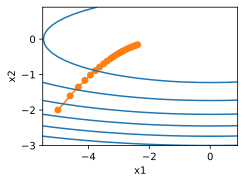

In [2]:
def adagrad_2d(x1, x2, s1, s2):
    eps = 1e-6
    g1, g2 = 0.2 * x1, 4 * x2
    s1 += g1 ** 2
    s2 += g2 ** 2
    x1 -= eta / math.sqrt(s1 + eps) * g1
    x2 -= eta / math.sqrt(s2 + eps) * g2
    return x1, x2, s1, s2

def f_2d(x1, x2):
    return 0.1 * x1 ** 2 + 2 * x2 ** 2

eta = 0.4
d2l.show_trace_2d(f_2d, d2l.train_2d(adagrad_2d))

当我们把学习率提高到$2$时，我们看到了更好的表现。这已经表明，即使在没有噪声的情况下，降低学习率可能也过于激进，我们需要确保参数能够适当收敛。

epoch 20, x1: -0.002295, x2: -0.000000


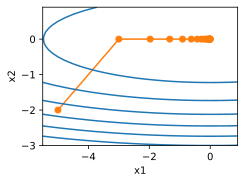

In [3]:
eta = 2
d2l.show_trace_2d(f_2d, d2l.train_2d(adagrad_2d))

## 从零开始实现

就像动量法一样，Adagrad 需要维护一个与参数形状相同的变量。

In [4]:
def init_adagrad_states(feature_dim):
    s_w = torch.zeros((feature_dim, 1))
    s_b = torch.zeros(1)
    return (s_w, s_b)

def adagrad(params, states, hyperparams):
    eps = 1e-6
    for p, s in zip(params, states):
        with torch.no_grad():
            s[:] += torch.square(p.grad)
            p[:] -= hyperparams['lr'] * p.grad / torch.sqrt(s + eps)
        p.grad.data.zero_()

与:numref:`sec_minibatch_sgd`中的实验相比，我们使用了更大的学习率来训练模型。

loss: 0.243, 0.162 sec/epoch


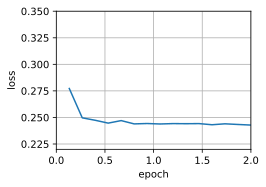

In [5]:
data_iter, feature_dim = d2l.get_data_ch11(batch_size=10)
d2l.train_ch11(adagrad, init_adagrad_states(feature_dim),
               {'lr': 0.1}, data_iter, feature_dim);

## 简洁实现

使用算法 `adagrad` 的 `Trainer` 实例，我们可以在Gluon中调用Adagrad算法。

loss: 0.242, 0.129 sec/epoch


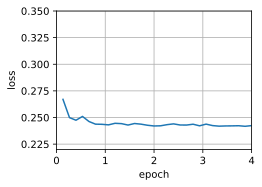

In [6]:
trainer = torch.optim.Adagrad
d2l.train_concise_ch11(trainer, {'lr': 0.1}, data_iter)

## 摘要

* Adagrad 会根据每个坐标动态地减少学习率。
* 它利用梯度的大小作为调整进度快慢的手段——梯度较大的坐标通过较小的学习率得到补偿。
* 在深度学习问题中，由于内存和计算限制，通常无法计算精确的二阶导数。梯度可以作为一个有用的替代。
* 如果优化问题具有相当不均匀的结构，Adagrad 可以帮助减轻这种扭曲。
* 对于稀疏特征，Adagrad 特别有效，其中对于出现频率较低的项，学习率需要更缓慢地下降。
* 在深度学习问题上，Adagrad 有时在降低学习率方面过于激进。我们将在 :numref:`sec_adam` 的背景下讨论缓解这一问题的策略。

## 练习

1. 证明对于正交矩阵 $\mathbf{U}$ 和向量 $\mathbf{c}$ 以下成立：$\|\mathbf{c} - \mathbf{\delta}\|_2 = \|\mathbf{U} \mathbf{c} - \mathbf{U} \mathbf{\delta}\|_2$。为什么这意味着在经过正交变量变换后扰动的幅度不会改变？
1. 尝试使用 Adagrad 对 $f(\mathbf{x}) = 0.1 x_1^2 + 2 x_2^2$ 以及目标函数旋转45度的情况，即 $f(\mathbf{x}) = 0.1 (x_1 + x_2)^2 + 2 (x_1 - x_2)^2$。它的行为是否不同？
1. 证明 [Gerschgorin 圆盘定理](https://en.wikipedia.org/wiki/Gershgorin_circle_theorem)，该定理表明矩阵 $\mathbf{M}$ 的特征值 $\lambda_i$ 满足 $|\lambda_i - \mathbf{M}_{jj}| \leq \sum_{k \neq j} |\mathbf{M}_{jk}|$ 至少对于一个 $j$ 成立。
1. Gerschgorin 定理告诉我们关于对角预处理矩阵 $\textrm{diag}^{-\frac{1}{2}}(\mathbf{M}) \mathbf{M} \textrm{diag}^{-\frac{1}{2}}(\mathbf{M})$ 的特征值什么信息？
1. 在适当的深度网络上尝试 Adagrad，例如当应用于 Fashion-MNIST 时的 :numref:`sec_lenet`。
1. 为了实现学习率较不激进的衰减，你需要如何修改 Adagrad？

[讨论](https://discuss.d2l.ai/t/1072)